In [28]:
import jax
from jax import random, jit
from functools import partial # needed to make arguments static in jit compiled code
import jax.numpy as jnp
import numpy as np
from tqdm import trange
from optax import adam
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import os

In [31]:
# https://github.com/google-deepmind/dm-haiku/issues/18#issuecomment-981814403
MODELS_PATH = "../model/"
def save_models(model, path: str):
    with open(os.path.join(MODELS_PATH, path), "wb") as file:
        pickle.dump(model, file)

In [ ]:
# because Apple sucks
jax.default_device = jax.devices("cpu")[0]

In [ ]:
seed = 1
key = random.PRNGKey(seed)
key

In [ ]:
# random data to fix some parameters in this mess
N = 1000
d = 10
n_classes = 10

key, key_X, key_y = random.split(key, 3)

X = random.normal(key_X, (N, d))
y = jax.nn.one_hot(random.randint(key_y, (N,), 0, n_classes), n_classes)

In [ ]:
y[:1]

Our model where $\theta$ and $\phi$ are learnable parameters:

In [ ]:
def p_theta_xzy(theta: jnp.ndarray, x: float, z: float, y:float ) -> float:
    pass

def q_phi_z_xy(phi: jnp.ndarray, z: float, x: float, y: float) -> float:
    pass

Here are the loss functions defined in "Auto Encoding Varational Bayes" to approximate the true ELBO $\cal L$:

$$
\widetilde{\cal L}^{A}(\theta,\phi;{\bf x}^{(i)}, {\bf y}^{(i)})=\frac{1}{L}\sum_{l=1}^{L}\log p_{\theta}({\bf x}^{(i)},{\bf z}^{(i,l)},{\bf y}^{(i)})-\log q_{\phi}({\bf z}^{(i,l)}|{\bf x}^{(i)}, {\bf y}^{(i)})
$$

$$

\widetilde{\cal L}^{B}(\theta,\phi;{\bf x}^{(i)}, {\bf y}^{(i)})=-D_{K L}(q_{\phi}({\bf z}|{\bf x}^{(i)}, {\bf y}^{(i)})||p_{\theta}({\bf z}))+\frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}({\bf x}^{(i)}|{\bf z}^{(i,l)}, {\bf y}^{(i)})

$$

$$

\widetilde{\cal L}^{M}(\theta,\phi;{\bf X}^{M}, {\bf y}^{M}, {\bf \epsilon})=\frac{1}{M}\sum_{i=1}^{M}=\widetilde{\cal L}^{A/B}(\theta,\phi;{\bf X}^{M}_i, {\bf y}^{M}_i)

$$

In [ ]:
def loss_A(theta: jnp.ndarray, phi: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray, eps: jnp.ndarray) -> float:
    return 0

def loss_B(theta: jnp.ndarray, phi: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray, eps: jnp.ndarray) -> float:
    return 0

Noise distribution $p$ that parameterises latent variable $z$, i.e. $z = g_{\theta}(\epsilon, x, y)$ where $\epsilon\sim p(\epsilon)$.

In [ ]:
def sample_p(keys: np.ndarray) -> np.ndarray:
    pass

In [ ]:
@partial(jit, static_argnames=['learning_rate'])
def update_sgd(grad_theta: np.ndarray, grad_phi: np.ndarray, learning_rate: float):
    return -learning_rate * grad_theta, -learning_rate * grad_phi

In [ ]:
# for the validation loss logging
n_log_validation = 100

# definition of remaining parameters
M = 10
N_trains = 10
d_eps = 10

# gradient descent method and associated parameters: use optimisation algo implemented in Optax if needed
learning_rate = 0.01
update = update_sgd

# used loss function
loss = loss_A

# initial parameter values
theta_0 = jnp.ones(10)
phi_0 = jnp.ones(10)

# optimised parameters
theta = jnp.copy(theta_0)
phi = jnp.copy(phi_0)

#sink for the loss values
training_steps, validation_steps = [], []
training_loss_values, validation_loss_values = [], []

# training loop
for iteration in trange(N_trains):
    # sample X^M, y^M mini-batches
    key, batch_key = random.split(key)
    indexes = random.choice(batch_key, M)
    X_M = X[indexes, ...]
    y_M = y[indexes, ...]

    # sample from noise distribution
    key, *sample_keys = random.split(key, d_eps+1)
    eps = sample_p(sample_keys)

    #compute the loss value and grad w.r.t. phi/theta
    grad_theta = jax.grad(loss, argnums=0)(theta, phi, X_M, y_M, eps)
    loss_value, grad_phi = jax.value_and_grad(loss, argnums=1)(theta, phi, X_M, y_M, eps)
    
    # log the training loss: here it's just the batch loss, need to be fixed.
    training_loss_values.append(loss_value)
    training_steps.append(iteration)

    # log the validation loss for some steps
    if iteration % n_log_validation == 0:
        validation_loss_value = compute_validation_loss(theta, phi)
        validation_loss_values.append(validation_loss_value)
        validation_steps.append(iteration)

    # update the parameters according to chosen policy
    theta, phi += update(grad_theta, grad_phi, learning_rate=learning_rate)

save_models({
    "learning_rate": learning_rate,
    "N_trains": N_trains,
    "M": M,
    "theta": theta,
    "phi": phi,
}, f"models/test_{datetime.today().strftime('%Y-%m-%d_%H:%M:%S')}.pkl")

Here is the resulting training/test loss plot:

NameError: name 'training_steps' is not defined

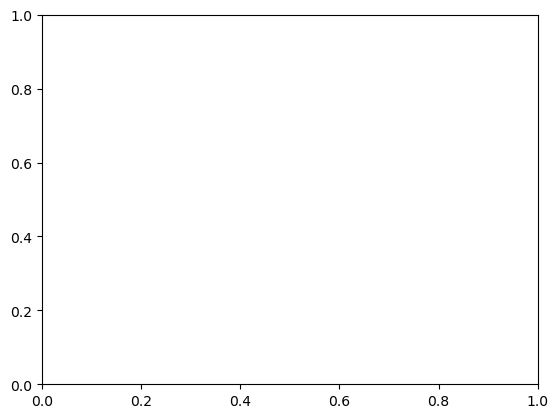

In [26]:

fig, ax = plt.subplots()
ax.plot(training_steps, training_loss_values, label=["training"])
ax.plot(validation_steps, validation_loss_values, label=["validation"])
ax.set_xlabel("iteration")
fig.suptitle("Loss values during training")
_ = ax.set_ylabel("$\cal L$")